In [123]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

In [124]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7784/1048885480.py:2: DtypeWarning: Columns (10,16,20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.094799,0.089899,1.822129,13.320908,0.024299,-0.002262,0.685764,0.0,simulation,NaN,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,-1.0,-1.0,42.0,NaN
1,0.006601,0.002868,1.909160,16.506168,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,-1.0,-1.0,42.0,NaN
2,0.000610,0.000559,1.911469,15.353169,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,-1.0,-1.0,42.0,NaN
3,0.000458,0.000432,1.911596,15.016453,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,-1.0,-1.0,42.0,NaN
4,0.000504,0.000477,1.911550,14.914031,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,-1.0,-1.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250402,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
250403,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
250404,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
250405,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [125]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma
    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, torch.nan]) # allows curve

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & bound_func]

    return df_subsetted

In [126]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma=-1",
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

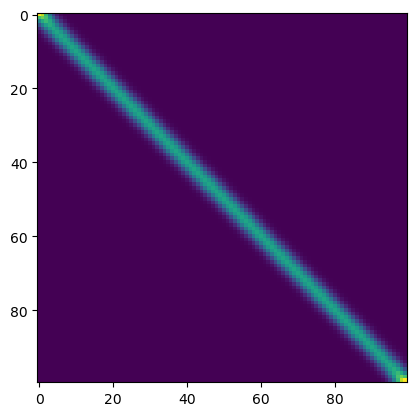

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

In [128]:
# visualize the curve!
df = get_df_subsetted_by_meaning_dists(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
104955,1.818470e+00,1.768627e+00,1.712146,108.789505,0.01297,-0.013747,0.768986,0.0,simulation,NaN,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
104956,9.536743e-07,9.536743e-07,3.480772,1664.730700,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
104957,0.000000e+00,9.536743e-07,3.480772,1538.123300,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
104958,0.000000e+00,0.000000e+00,3.480775,1434.872300,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
104959,0.000000e+00,9.536743e-07,3.480772,1351.855300,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228355,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
228356,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
228357,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
228358,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo


In [129]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

In [130]:
langs = df_final_points[df_final_points["population_init_gamma"] == -3]
langs

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
104955,1.818470,1.768627,1.712146,108.789505,0.012970,-0.013747,0.768986,0.0,simulation,NaN,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
106369,2.456265,2.324291,1.156482,49.261547,0.000929,-0.004369,0.852208,0.0,simulation,NaN,...,-8,100,squared_dist,-2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
107783,2.865984,2.635403,0.845370,31.872974,0.000204,-0.001612,0.975377,0.0,simulation,NaN,...,-8,100,squared_dist,-1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
109197,2.986859,2.717516,0.763257,28.463264,0.000224,0.000002,1.031968,0.0,simulation,NaN,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
110611,3.006477,2.730243,0.750530,27.981297,0.000226,0.000414,1.041955,0.0,simulation,NaN,...,-8,100,squared_dist,1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
112025,3.006480,2.730246,0.750527,27.981209,0.000227,0.000415,1.041955,0.0,simulation,NaN,...,-8,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
113439,3.006480,2.730246,0.750527,27.981209,0.000227,0.000415,1.041955,0.0,simulation,NaN,...,-8,100,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


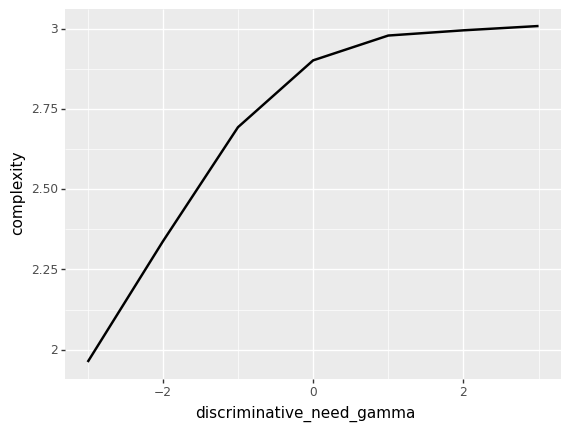

<ggplot: (381668995)>

In [131]:
(
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_smooth()
)

In [132]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]


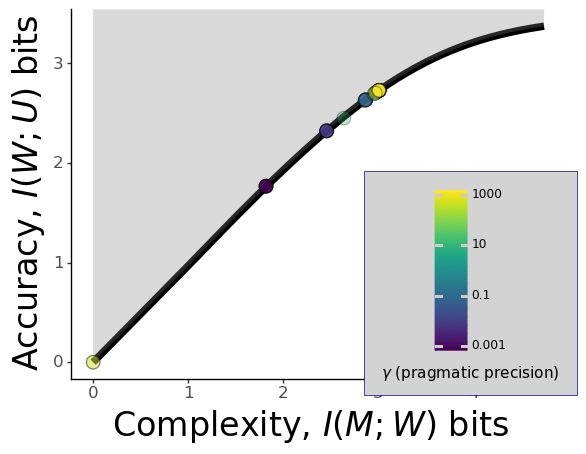

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: evolang_figure


In [133]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
        alpha=0.3,
        size=10,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)
plot.save("evolang_figure", width=6, height=6, dpi=300,)

In [134]:
df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]
df_traj_points


new_df = df_traj_points.loc[(df_traj_points['population_init_gamma'] == -3) & (df_traj_points["discriminative_need_gamma"] == 2)]

new_df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,iteration
112026,9.536743e-07,9.536743e-07,3.480772,1664.730700,NaN,NaN,NaN,1.0,trajectory,0.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,0.0
112027,0.000000e+00,9.536743e-07,3.480772,1663.557500,NaN,NaN,NaN,1.0,trajectory,1.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,1.0
112028,0.000000e+00,0.000000e+00,3.480773,1662.648000,NaN,NaN,NaN,1.0,trajectory,2.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,2.0
112029,3.814697e-06,3.814697e-06,3.480769,1661.889300,NaN,NaN,NaN,1.0,trajectory,3.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,3.0
112030,2.098083e-05,1.907349e-05,3.480754,1661.222500,NaN,NaN,NaN,1.0,trajectory,4.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112221,3.006485e+00,2.730246e+00,0.750526,27.981134,NaN,NaN,NaN,1.0,trajectory,195.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,195.0
112222,3.006483e+00,2.730246e+00,0.750526,27.981153,NaN,NaN,NaN,1.0,trajectory,196.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,196.0
112223,3.006483e+00,2.730246e+00,0.750527,27.981170,NaN,NaN,NaN,1.0,trajectory,197.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,197.0
112224,3.006481e+00,2.730246e+00,0.750527,27.981190,NaN,NaN,NaN,1.0,trajectory,198.0,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,198.0


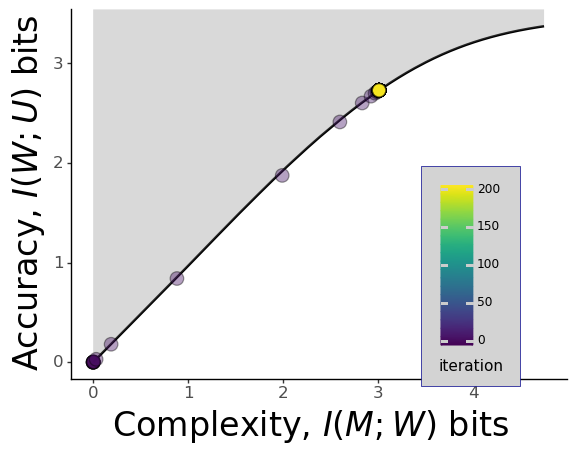

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: evolang_traj_figure


In [135]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )

    + pn.labs(fill="iteration")
    + pn.scale_fill_continuous(
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("evolang_traj_figure", width=6, height=6, dpi=300,)